                            - DỰ ĐOÁN GIÁ CLOSE CHO TẬP DỮ LIỆU CTLT.csv

IMPORT THƯ VIỆN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ĐỌC DỮ LIỆU

In [2]:
# Đọc dữ liệu
stock_intc = pd.read_csv('../../Dataset/INTC.csv')

# Column Date là object => đổi sang dạng datetime
stock_intc['Date'] = pd.to_datetime(stock_intc.Date,format='%Y/%m/%d')

# Cho Cột Date làm giá trị index => in đc giá trị x là cột Date
stock_intc = stock_intc.set_index(pd.DatetimeIndex(stock_intc['Date'].values))

THÔNG SỐ TẬP DỮ LIỆU

In [3]:
print("Độ dài giá trị có trong cột Close: ", stock_intc['Close'].count())
print("Giá trị max của cột Close:", stock_intc['Close'].max())
print("Giá trị min của cột Close:", stock_intc['Close'].min())
print("Q1:", np.percentile(stock_intc['Close'], 25))
print("Q2:", np.percentile(stock_intc['Close'], 50))
print("Q3:", np.percentile(stock_intc['Close'], 75))

Độ dài giá trị có trong cột Close:  1051
Giá trị max của cột Close: 68.470001
Giá trị min của cột Close: 24.9
Q1: 45.790001
Q2: 50.849998
Q3: 56.4399985


CHUẨN HÓA DỮ LIỆU

In [4]:
# Tạo dataframe mới chỉ chứa cột Date và giá trị Close
df_intc = pd.DataFrame(stock_intc, columns=['Date', 'Close'])

# Bỏ cột date khỏi dataframe
df_intc.drop('Date', axis=1, inplace=True)

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
df_intc = scaler.fit_transform(np.array(df_intc).reshape(-1,1))

CHIA CÁC TẬP DỮ LIỆU

In [6]:
# Tính độ dài
    # Train: 60%
    # Test: 20%
    # Val: 20%
train_size = int(len(df_intc) * 0.6)
test_size = int(len(df_intc) * 0.2)
val_size = len(df_intc) - train_size - test_size

In [7]:
# Lấy dữ liệu
train_data = df_intc[:train_size]
test_data = df_intc[train_size:train_size+test_size]
val_data = df_intc[train_size+test_size:]

In [8]:
# Tạo dataset cho X, Y train, test, val
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - time_step - 1):
		a = dataset[i:(i + time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [9]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)

HUẤN LUYỆN VÀ TRAIN MÔ HÌNH

In [11]:
# Định nghĩa mô hình
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape = (100, 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
# Sử dụng early stoping để dừng khi không có cải thiện
earlystop = EarlyStopping(monitor='val_loss', patience=10)

In [13]:
# Train mô hình
model.fit(X_train, y_train, validation_data=(X_test, ytest), epochs = 100, batch_size = 64,verbose = 1,  callbacks=earlystop)

Epoch 1/100
9/9 [==============================] - 17s 592ms/step - loss: 0.1418 - val_loss: 0.0033
Epoch 2/100
9/9 [==============================] - 3s 356ms/step - loss: 0.0241 - val_loss: 0.0140
Epoch 3/100
9/9 [==============================] - 3s 294ms/step - loss: 0.0119 - val_loss: 0.0033
Epoch 4/100
9/9 [==============================] - 2s 253ms/step - loss: 0.0099 - val_loss: 0.0107
Epoch 5/100
9/9 [==============================] - 2s 252ms/step - loss: 0.0087 - val_loss: 0.0037
Epoch 6/100
9/9 [==============================] - 3s 376ms/step - loss: 0.0083 - val_loss: 0.0095
Epoch 7/100
9/9 [==============================] - 3s 299ms/step - loss: 0.0077 - val_loss: 0.0042
Epoch 8/100
9/9 [==============================] - 3s 382ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch 9/100
9/9 [==============================] - 5s 559ms/step - loss: 0.0068 - val_loss: 0.0051
Epoch 10/100
9/9 [==============================] - 3s 314ms/step - loss: 0.0066 - val_loss: 0.0048
Epoch 11

DỰ ĐOÁN TRÊN TẬP TEST VÀ TRAIN

In [14]:
# Dự đoán
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 1s 237ms/step


In [15]:
# Chuyển hóa dữ liệu lại như cũ
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

TÍNH ĐỘ LỖI CỦA MÔ HÌNH

In [16]:
# Độ lỗi mô hình trên tập test
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = mean_absolute_percentage_error(y_pred, ytest)
test_mse = mean_squared_error(y_pred, ytest)
test_rmse = np.sqrt(test_mse)

print(f"Testing MAE: ", test_mae)
print(f"Testing MAPE: ", test_mape)
print(f"Testing MSE: ", test_mse)
print(f"Testing RMSE: ", test_rmse)

Testing MAE:  50.18382533359596
Testing MAPE:  0.9889696246253451
Testing MSE:  2521.086110388753
Testing RMSE:  50.21041834508803


In [17]:
# Độ lỗi mô hình trên tập validation
val_mae = mean_absolute_error(y_pred_val, yval)
val_mape = mean_absolute_percentage_error(y_pred_val, yval)
val_mse = mean_squared_error(y_pred_val, yval)
val_rmse = np.sqrt(val_mse)

print(f"Validation MAE: ",val_mae)
print(f"Validation MAPE: ", val_mape)
print(f"Validation MSE: ", val_mse)
print(f"Validation RMSE: ", val_rmse)

Validation MAE:  32.690979997277594
Validation MAPE:  0.9979217415325722
Validation MSE:  1069.472366027672
Validation RMSE:  32.702788352488724


                                - DỰ ĐOÁN 30 NGÀY TIẾP THEO

In [18]:
x_input = val_data[5:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Khởi tạo giá trị chạy
i = 0

# List lưu trữ giá trị 30 ngày tiếp theo
prediction_next30_days = []

while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:])

        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)

        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose = 0)

        temp_input.extend(y_hat[0].tolist())

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1

In [19]:
# In ra giá trị dự đoán
print(prediction_next30_days)

[[0.15180140733718872], [0.1496897041797638], [0.1498175859451294], [0.15218308568000793], [0.15653419494628906], [0.1625072956085205], [0.16971701383590698], [0.17780718207359314], [0.18647626042366028], [0.19548514485359192], [0.2046540081501007], [0.21385496854782104], [0.2230021357536316], [0.2320413589477539], [0.24094152450561523], [0.24968749284744263], [0.2582744061946869], [0.26670342683792114], [0.27497878670692444], [0.2831062078475952], [0.29109179973602295], [0.29894083738327026], [0.3066582679748535], [0.3142482042312622], [0.3217138648033142], [0.32905828952789307], [0.33628347516059875], [0.3433913290500641], [0.3503839075565338], [0.35726234316825867]]


TRỰC QUAN HÓA TẤT CẢ DỮ LIỆU

In [20]:
# Lấy ra các ngày cuối cùng
last_date = stock_intc.index.max()
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

In [21]:
# Chuyển từ list thành dạng mảng
prediction_next30_days = np.array(prediction_next30_days)

# Chuyển đổi các giá trị trong đoạn 0 - 1 sang giá trị thực
prediction_next30_days = scaler.inverse_transform(prediction_next30_days).reshape(-1)

In [22]:
# Tạo dataframe chứa dữ liệu 30 ngày tới
future_data = pd.DataFrame({'Date': future_dates,
                            'Close': prediction_next30_days,
                            })
# Sắp xếp Date
future_data = future_data.sort_values(by='Date')

# Set index là Date
future_data.set_index('Date', inplace=True)

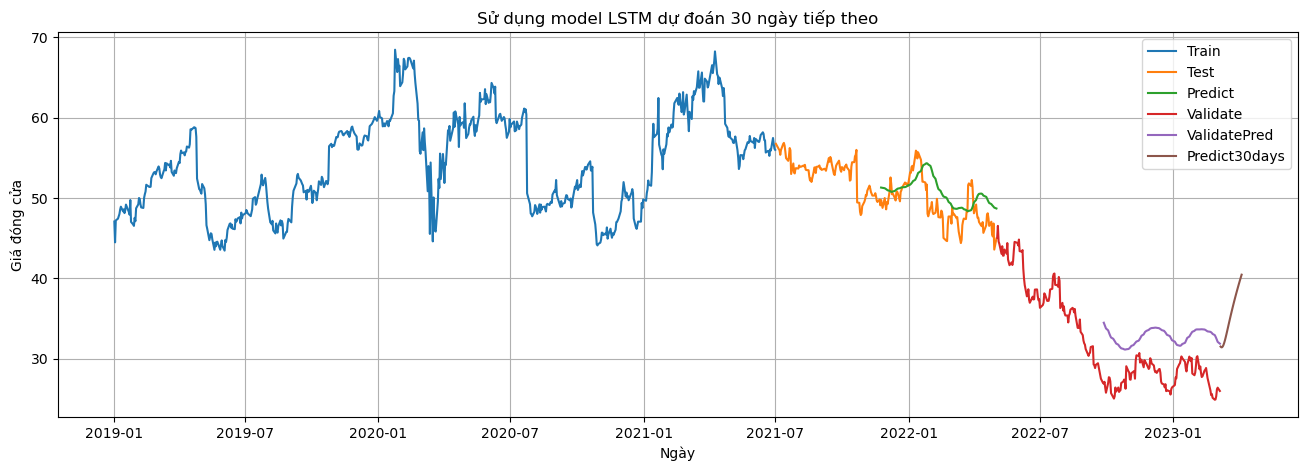

In [23]:
plt.figure(figsize=(16,5))

# Tập dữ liệu train
plt.plot(stock_intc.index[:train_size], scaler.inverse_transform(train_data))

# Tập dữ liệu Test
plt.plot(stock_intc.index[train_size:train_size + test_size], scaler.inverse_transform(test_data))

# Dữ liệu predict trên tập Test
plt.plot(stock_intc.index[train_size + time_step + 1: train_size + test_size],(y_pred))

# Tập dữ liệu Validate
plt.plot(stock_intc.index[train_size + test_size: train_size + test_size + val_size],scaler.inverse_transform(val_data))

# Dữ liệu predict trên tập Validate
plt.plot(stock_intc.index[train_size + test_size + time_step + 1: train_size + test_size + val_size],y_pred_val)

# Dự đoán cho 30 ngày tiếp theo
plt.plot(future_data.index, future_data['Close'])

plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.title('Sử dụng model LSTM dự đoán 30 ngày tiếp theo')
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.grid()
plt.show()